In [1]:
import os
import sys
import pickle

import mlflow
import torch
from torchvision.transforms import Compose, Resize, ToTensor, PILToTensor, ConvertImageDtype

ST_DIR = os.getcwd()
EXP_DIR = os.path.dirname(ST_DIR)
ROOT_DIR = os.path.dirname(EXP_DIR)
DATA_DIR = os.path.join(ROOT_DIR, 'data')
sys.path.append(ROOT_DIR)

from core.trainer import BinaryClassifierTrainer
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# model = torch.load(os.path.join(ROOT_DIR, "data", "model.pth"), map_location=torch.device(DEVICE))
model = mlflow.pytorch.load_model("file:///home/oem/repositories/mlflow_artifact/3/cabcd6e6865148f59464bfb408f53b24/artifacts/model")

2024/03/01 13:25:46 WARNING mlflow.pytorch: Stored model version '2.2.0+cu121' does not match installed PyTorch version '2.0.1+cu117'


In [2]:
import argparse
import glob
import copy
import numpy as np
import tqdm
from core.posthoc.grad_cam import grad_cam, postprocess_gcam
from core.transform import crop_ratio
from experiments.st._paths import DataPaths
from experiments.st.data_model import STImages
from experiments.st.datasets import STDataSet
from sklearn.model_selection import StratifiedKFold
from PIL import Image

ARGS = argparse.Namespace()
ARGS.seed = 42
ARGS.device = DEVICE
ARGS.batch_size = 1
ARGS.num_workers = 1
data_paths = DataPaths(DATA_DIR)

st_images = STImages(
    s_image_paths=glob.glob(str(data_paths.canon.s / "*")),
    t_image_paths=glob.glob(str(data_paths.canon.t / "*")),
)
transform = Compose(
    [PILToTensor(), Resize((512, 512)), ConvertImageDtype(torch.float)]
)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=ARGS.seed)
for fold, (train_indices, test_indices) in enumerate(
    stratified_kfold.split(st_images.image_paths, st_images.labels), start=1):
    
    if fold != 1:
        continue
    
    test_images = st_images[test_indices]
    confidence_container = np.zeros((len(test_indices), 10))
    for i, (test_image, label) in enumerate(tqdm.tqdm(test_images)):
        crop_image, (_, _) = crop_ratio(np.array(Image.open(test_image)), is_st=True)
        image_pil = Image.fromarray(crop_image)
        cam, confidence = grad_cam(model, transform(image_pil).unsqueeze(0).to(DEVICE), model.layer4[-1])
        cam_post = postprocess_gcam(cam, (512, 512))
        
        if label != 1:
            confidence_container[i,:] = confidence
            continue
        
        for j in range(1, 11):
            flattened_matrix = cam_post.ravel()
            num_elements = len(flattened_matrix)
            lbound = np.percentile(flattened_matrix, 10 * j)
            indices = np.where(flattened_matrix <= lbound)

            mask_indices = np.unravel_index(indices, (512,512))
            x, y = mask_indices
            
            resized_image = Image.fromarray(crop_image).resize((512, 512))
            resized_image_array = copy.deepcopy(np.array(resized_image))
            resized_image_array[x, y, :] = 0
            new_x = transform(Image.fromarray(resized_image_array)).unsqueeze(0).to(DEVICE)
            confidence = torch.sigmoid(model(new_x.to(DEVICE))).item()
            confidence_container[i,j-1] = confidence

    np.save("confidence_container", confidence_container)
      

  0%|                                                                                                                                                                             | 0/3480 [00:00<?, ?it/s]/home/oem/anaconda3/envs/breast/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/oem/anaconda3/envs/breast/lib/python3.8/site-packages/to

(0.0, 1.0)

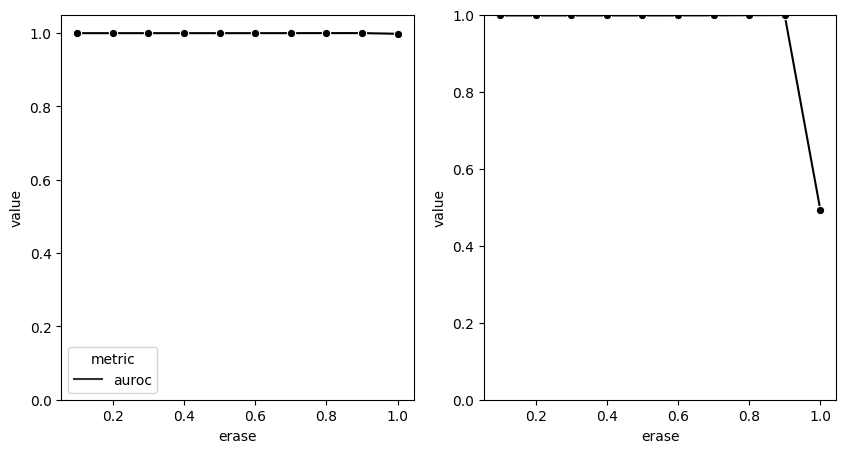

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from matplotlib import pyplot as plt

aurocs = list()
praucs = list()
for mask_iter in range(0, 10):
    test_confidences = confidence_container[:, mask_iter].ravel()
    precision, recall, t = precision_recall_curve(test_images.labels, test_confidences)
    praucs.append([(mask_iter+1)*0.1, auc(recall, precision)])
    aurocs.append([(mask_iter+1)*0.1, roc_auc_score(test_images.labels, test_confidences)])

auroc_df = pd.DataFrame(aurocs, columns=["erase", "value"])
auroc_df["metric"] = "auroc"

prauc_df = pd.DataFrame(praucs, columns=["erase", "value"])
prauc_df["metric"] = "prauc"
df = pd.concat([auroc_df, prauc_df])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(
    df.loc[df["metric"] == "auroc"], 
    x="erase", 
    y="value",
    marker="o",
    style="metric",
    color="black",
    ax=axes[0],
)
axes[0].set_ylim(0, 1.05)

sns.lineplot(
    df.loc[df["metric"] == "prauc"], 
    x="erase", 
    y="value",
    marker="o",
    color="black",
    ax=axes[1],
)
axes[1].set_ylim(np.arange(0, 1.5))

In [5]:
df

,erase,value,metric
0,0.1,0.999715,auroc
1,0.2,0.999715,auroc
2,0.3,0.999715,auroc
3,0.4,0.999715,auroc
4,0.5,0.999717,auroc
5,0.6,0.999727,auroc
6,0.7,0.999760,auroc
7,0.8,0.999827,auroc
8,0.9,0.999872,auroc
9,1.0,0.997997,auroc


/home/oem/anaconda3/envs/breast/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/oem/anaconda3/envs/breast/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missin

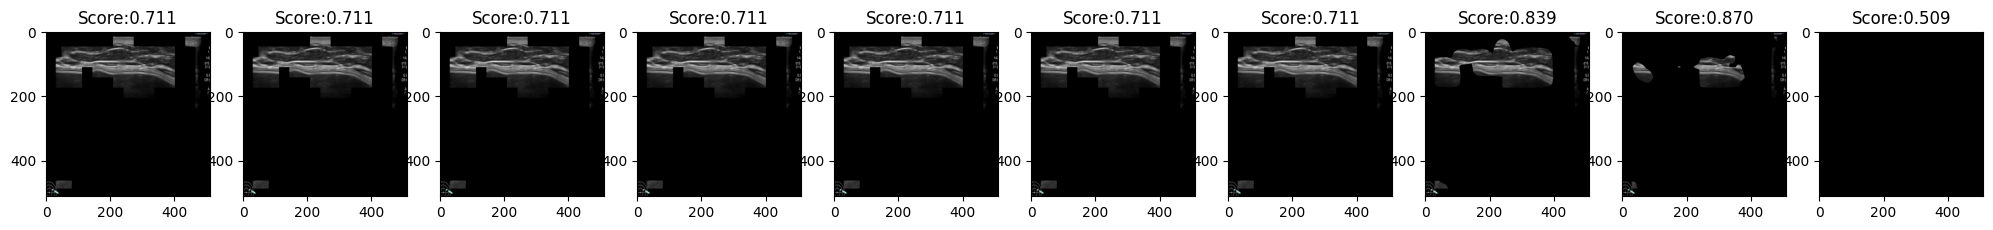

In [4]:
import copy
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(25, 15))
for i in range(1, 11):
    flattened_matrix = cam_post.ravel()
    num_elements = len(flattened_matrix)
    lbound = np.percentile(flattened_matrix, 10 * i)
    indices = np.where(flattened_matrix <= lbound)

    mask_indices = np.unravel_index(indices, (512,512))
    x, y = mask_indices
    
    resized_image = Image.fromarray(crop_image).resize((512, 512))
    resized_image_array = copy.deepcopy(np.array(resized_image))
    resized_image_array[x, y, :] = 0
    new_x = transform(Image.fromarray(resized_image_array)).unsqueeze(0).to(DEVICE)
    confidence = torch.sigmoid(model(new_x)).item()
    axes[i - 1].imshow(resized_image_array)
    axes[i - 1].set_title("Score:"+f'{confidence:.3f}')